## Import packages

In [1]:
import warnings
import pandas as pd, numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import pickle

## bulid AIC Model to test the parameters for SARIMA/ARIMA/ETS

In [2]:
def AIC(exog, parameters_list, T):
    """Return parameters and AIC       
        parameters_list - list with (p,d,q,P,D,Q,s) 
        p - Trend autoregression order
        d - Trend difference order
        q - Trend moving average order
        P - Seasonal autoregressive order
        D - Seasonal difference order
        Q - Seasonal moving average order
        s - The number of time steps for a single seasonal period.
    """
    results = []
    #Progress bar for jupyter notebook    
    for param in tqdm_notebook(parameters_list):
        try:
            if T =='SARIMA':
                #order=(p,d,q), seasonal_order=(P,D,Q,s), disp<0 means no output information print
                model = SARIMAX(exog, order=(param[:3]), seasonal_order=(param[3:])).fit(disp=-1)
            elif T =='ARIMA':
                model = SARIMAX(exog, order=param).fit(disp=-1)
            elif T == 'ETS':
                model = ExponentialSmoothing(exog, trend=param[0], seasonal=param[1], seasonal_periods=param[2], damped=param[3]).fit()
        except:
            continue
        aic = model.aic
        results.append([param, aic])
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['Parameters', 'AIC']
    
    #Sorting AIC with the sort_values(), in an ascending order
    result_table = result_table.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_table

## Add time features for ML

In [3]:
def create_time_features(data, target=None):
    """
    Creates time series features from datetime index
    """
    df = data.copy()
    df['date'] = df.index
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    X = df.drop(['date'], axis=1)
    if target:
        y = X[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

## Read Data

In [4]:
data = pd.read_csv('verkehrsunfaelle.csv')

## Data Cleansing

In [5]:
data.info()
data = data[['MONATSZAHL','AUSPRAEGUNG','MONAT','WERT']]

#isnull() identifies whether the element in the data is a null value
#any() identifies whether the row has a null value (axis=1)
null = data[data.isnull().any(axis=1)]

#Delete rows with null values (axis=0)
data = data.dropna()
# ~ to invert boolean series, isin (identifies row containing 'Summe')
data = data[~data['MONAT'].isin(['Summe'])]
data = data[data['AUSPRAEGUNG'].isin(['insgesamt'])]
#find accident categories
category = data['MONATSZAHL'].unique()

#Create 'unfall' to save the collated data, make it more readable
unfall = pd.DataFrame()
unfall['MONAT'] = data['MONAT'].unique()
for i in range(len(category)):
    #.loc[row,column], merge is like vlookup in Excel
    unfall = pd.merge(unfall, data[data['MONATSZAHL'].isin([category[i]])].loc[:,['MONAT','WERT']], how='left', on='MONAT')
    #rename 'WERT'
    unfall.rename(columns={'WERT':category[i]},inplace=True)

#Add time series index
unfall.rename(columns={'MONAT':'Date'},inplace=True)
#unfall['Date'] = unfall['Date'].apply(lambda x : pd.to_datetime(str(x), format='%Y%m'))
unfall['Date'] = unfall['Date'].apply(lambda x : datetime.strptime(x, '%Y%m'))
#sorting 'Date' in an ascending order
unfall = unfall.sort_values(by = 'Date')
unfall.set_index('Date', inplace=True)
unfall.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2086 entries, 0 to 2085
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONATSZAHL                      2086 non-null   object 
 1   AUSPRAEGUNG                     2086 non-null   object 
 2   JAHR                            2086 non-null   int64  
 3   MONAT                           2086 non-null   object 
 4   WERT                            2002 non-null   float64
 5   VORJAHRESWERT                   1995 non-null   float64
 6   VERAEND_VORMONAT_PROZENT        1840 non-null   float64
 7   VERAEND_VORJAHRESMONAT_PROZENT  1910 non-null   float64
 8   ZWOELF_MONATE_MITTELWERT        1848 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 146.8+ KB


,Alkoholunfälle,Fluchtunfälle,Verkehrsunfälle
Date,,,
2000-01-01,78.0,835.0,3448.0
2000-02-01,53.0,890.0,3181.0
2000-03-01,73.0,974.0,3783.0
2000-04-01,78.0,834.0,3317.0
2000-05-01,96.0,1086.0,4123.0


## Visualisation of three data sets

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

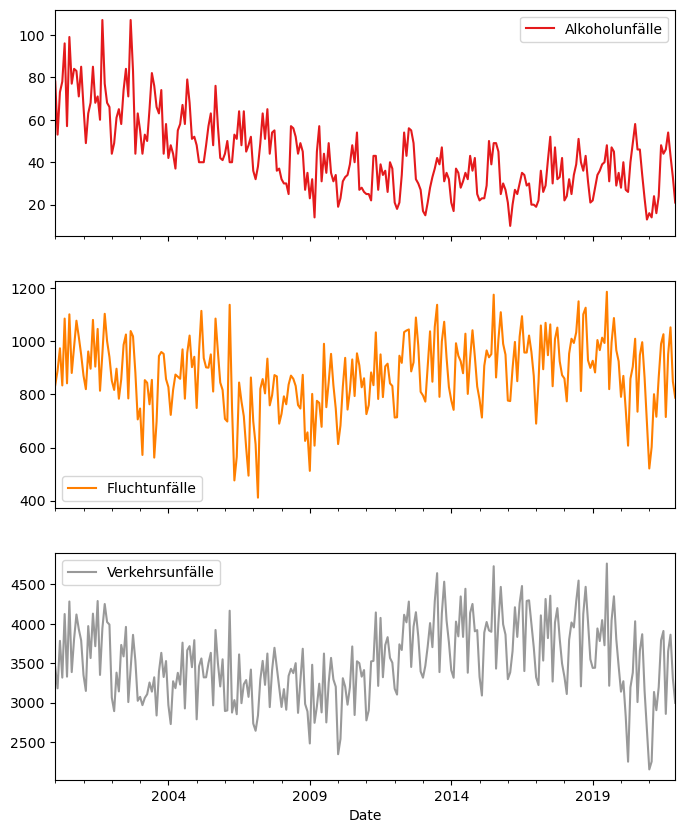

In [6]:
#Assume that traffic accidents do not include alcohol accidents and escape accidents.
#Alcohol Accidents have the lowest numbers and all three sets show some seasonality.
cmap = plt.get_cmap('Set1',3)
unfall.plot(subplots=True, figsize=(8,10), colormap=cmap)

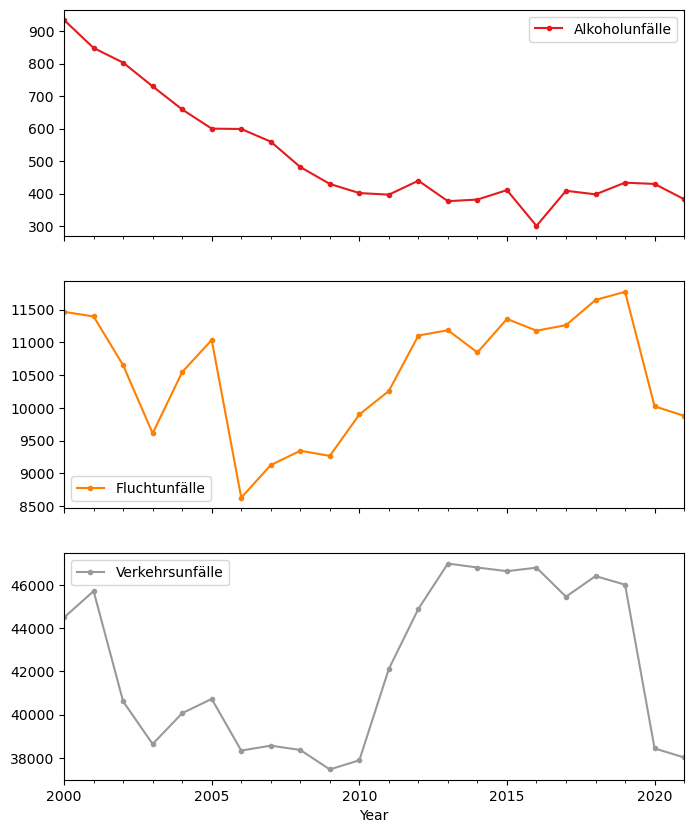

In [7]:
#Annual Traffic Accidents
#Alcohole Accidents show a decreasing trend.
unfall.resample('Y').sum().plot(subplots=True, figsize=(8,10), xlabel='Year',colormap=cmap, style='.-')
plt.show()

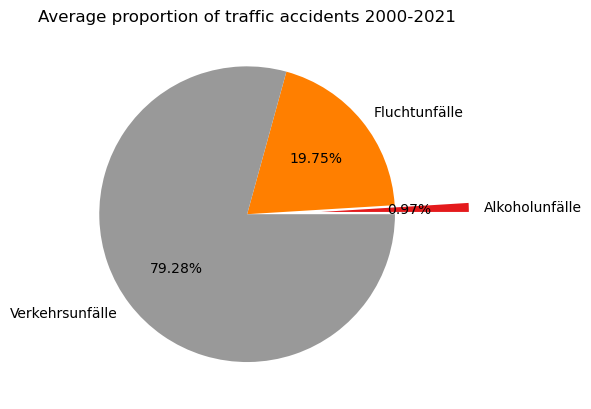

In [8]:
#Average percentage of traffic accidents in Pie Chart
#highlights the proportion of accidents
plt.pie(
        unfall.mean(),
        labels=[category[0],category[1],category[2]],
        colors= cmap.colors,
        explode=(0.5, 0, 0),
        autopct='%.2f%%'
        )
plt.title('Average proportion of traffic accidents 2000-2021')
plt.show()

<AxesSubplot:title={'center':'Monthly accidents as a proportion of the year (Average)'}, xlabel='Month'>

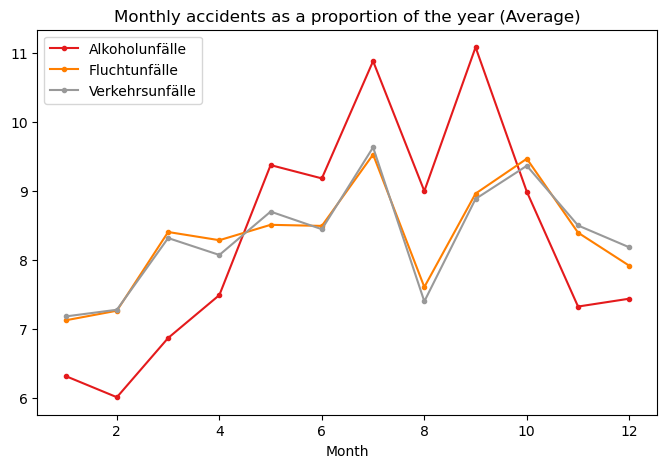

In [9]:
#Monthly accidents as a proportion of the year (Average)
#High correlation between escape accidents and traffic accidents.
#July, September and October are the peak months of the year.
unfall_month= unfall.set_index(unfall.index.month) #DatetimeIndex
unfall_month=100*unfall_month.groupby('Date').agg('mean')/(12*unfall_month.mean())

unfall_month.plot(
                  colormap=cmap, style='.-',
                  title='Monthly accidents as a proportion of the year (Average)',
                  xlabel='Month',
                  figsize=(8,5)
                  )

<AxesSubplot:xlabel='Date'>

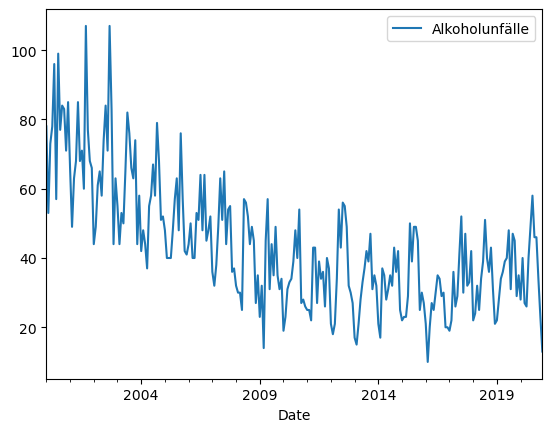

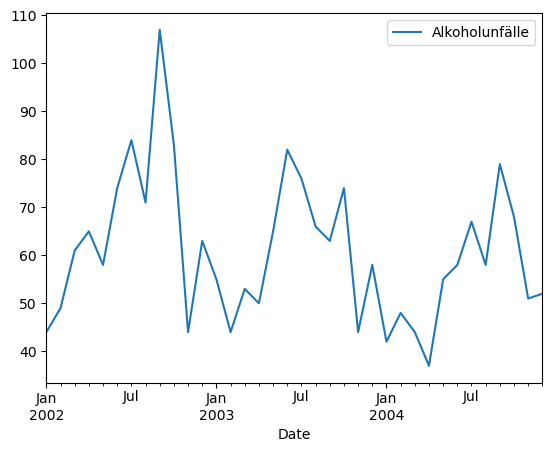

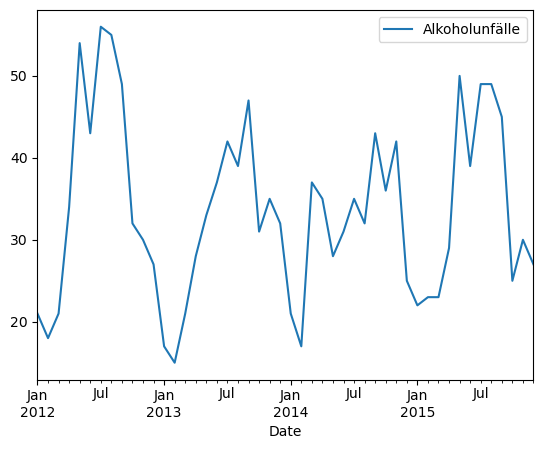

In [10]:
#%%Split data of Alkoholunfälle after 2020 
train = unfall.loc['2000':'2020',[category[0]]].copy()
test = unfall.loc['2021',[category[0]]].copy()
train.plot()

#To see if it has seasonal characteristic
train['2002':'2004'].plot()
train['2012':'2015'].plot()

## Stationary test (Augmented Dickey-Fuller Test)

p-value: 0.061415
Diff1-p-value: 0.000160
Diff1_seasonal-p-value: 0.000000


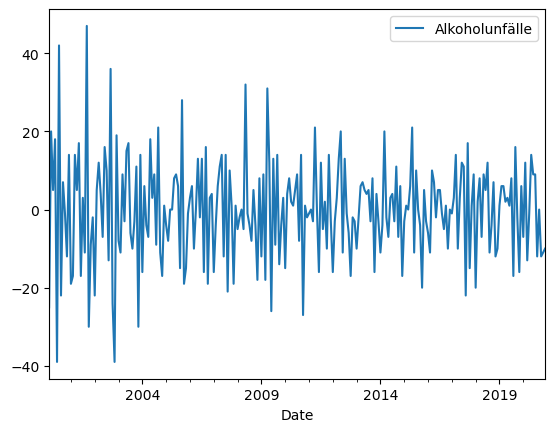

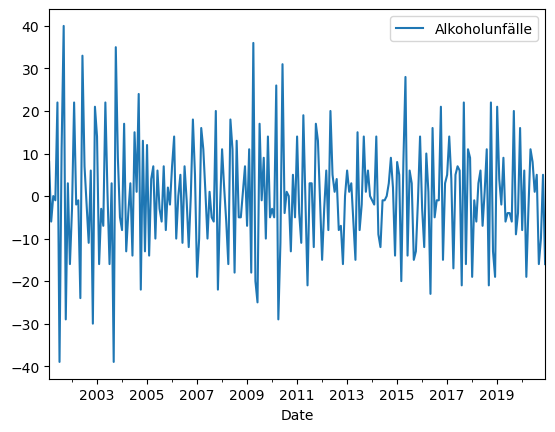

In [11]:
#Calculate first differencing of the series
diff1 = train.diff(1).dropna()
diff1.plot()

#took the difference over a period of 12 months
#shows that the order of seasonal differencing (D) is 1
diff1_seasonal = diff1.diff(12).dropna()
diff1_seasonal.plot()

print("p-value: %f" %adfuller(train)[1])
#stationary from the result of Augmented Dickey-Fuller Test
print("Diff1-p-value: %f" %adfuller(diff1)[1])
print("Diff1_seasonal-p-value: %f" %adfuller(diff1_seasonal)[1])

## ACF and PACF (with first difference and seasonal difference)

       lb_stat     lb_pvalue     bp_stat     bp_pvalue
1    34.164599  5.064189e-09   33.739313  6.301426e-09
2    41.030703  1.231107e-09   40.491458  1.612099e-09
3    43.390677  2.033089e-09   42.802469  2.710498e-09
4    44.361318  5.397441e-09   43.748945  7.234164e-09
5    44.394926  1.925694e-08   43.781576  2.565151e-08
6    44.399907  6.157905e-08   43.786393  8.149226e-08
7    45.061526  1.330504e-07   44.423304  1.769379e-07
8    45.590492  2.843341e-07   44.930321  3.793594e-07
9    46.493829  4.875306e-07   45.792427  6.580585e-07
10   51.525866  1.396478e-07   50.573905  2.092754e-07
11   58.589939  1.692747e-08   57.256930  2.983723e-08
12  105.031615  5.721060e-17  101.000748  3.544357e-16



/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


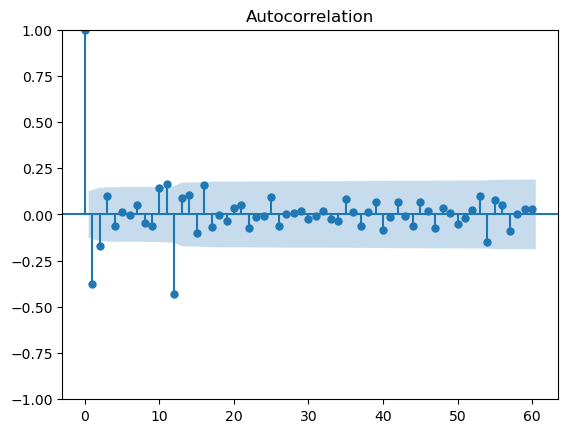

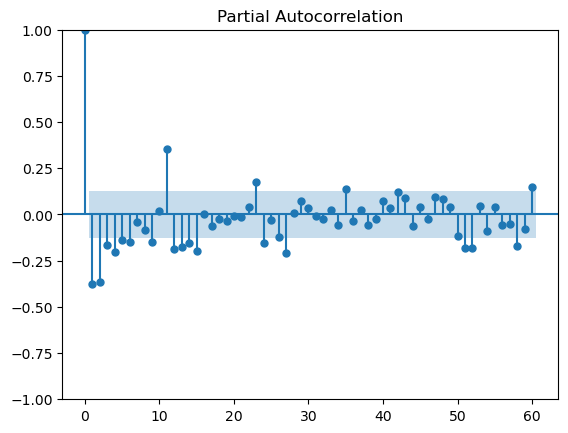

In [12]:
#not white noise
print(acorr_ljungbox(diff1_seasonal, lags=12, boxpierce=True,return_df=True))


#ACF shows significant spikes at lag 1 or 2, q could be 1 or 2
#ACF also shows significant spikes at lag 12, Q coulld be 1.
plot_acf(diff1_seasonal, lags=60)
#PACF has a significant peak at lag 0, which suggest AR(0) p=0
#PACF has not significant peak at lag 12/24, which suggest P=0 (a seasonal autoregressive process of order 0)
plot_pacf(diff1_seasonal, lags=60)
#for jupyter plot twice bug...use print(),
print()

In [13]:
unfall_alcohol = pd.DataFrame(unfall[category[0]].copy())

## ARIMA Model

In [14]:
#%% Apply AIC model, determine parameters for ARIMA
p_a = range(0,4)
d_a = range(1,2) #which is 1
q_a = range(0,4)
model_type = 'ARIMA'

parameters_arima = list(product(p_a,d_a,q_a))
len(parameters_arima)
warnings.filterwarnings("ignore") 
AIC_arima = AIC(train, parameters_arima, model_type)

p_a, d_a, q_a = AIC_arima['Parameters'][0]

  0%|          | 0/16 [00:00<?, ?it/s]

                               SARIMAX Results                                
Dep. Variable:         Alkoholunfälle   No. Observations:                  252
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -916.554
Date:                Wed, 30 Nov 2022   AIC                           1845.107
Time:                        22:53:55   BIC                           1866.260
Sample:                    01-01-2000   HQIC                          1853.620
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7285      0.004    417.670      0.000       1.720       1.737
ar.L2         -0.9960      0.005   -210.371      0.000      -1.005      -0.987
ma.L1         -2.5846      0.049    -53.166      0.0

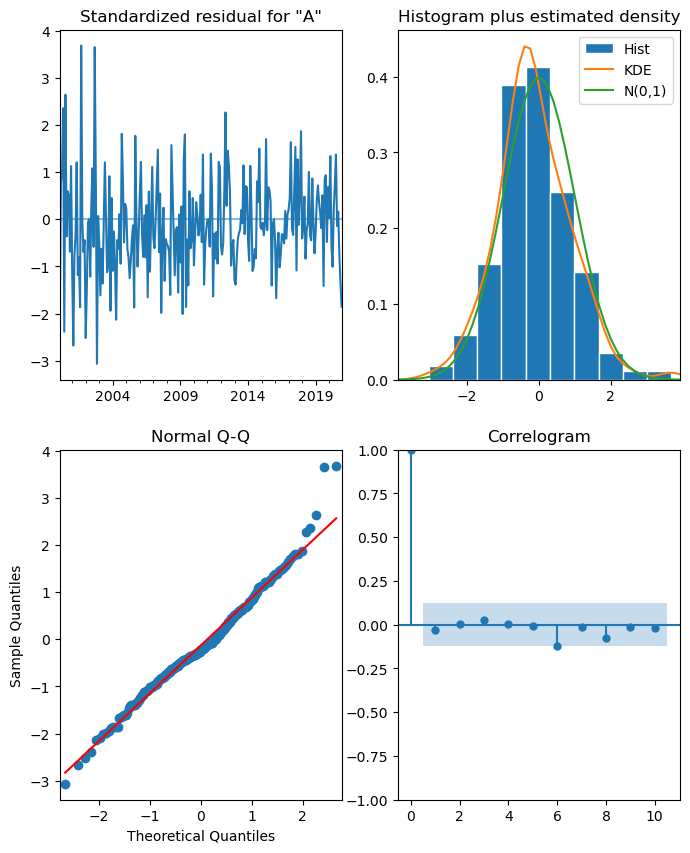

In [15]:
#%%Apply ARIMA, save prediction results
train_arima = SARIMAX(train, order=(p_a,d_a,q_a)).fit(disp=-1)
print(train_arima.summary())
train_arima.plot_diagnostics(figsize=(8,10))

unfall_alcohol['ARIMA'] = train_arima.fittedvalues.round()
unfall_alcohol['ARIMA'][:d_a] = np.NAN
unfall_alcohol['ARIMA'][test.index] = train_arima.predict(start=test.index[0], end=test.index[-1]).round()
unfall_alcohol['D_ARIMA'] = (unfall_alcohol['ARIMA']-unfall_alcohol[category[0]])

rmse_arima = sqrt(mean_squared_error(test, unfall_alcohol['2021']['ARIMA'])) 

## SARIMA Model

In [16]:
#%% Apply AIC model, determine parameters for SARIMA
p_s = range(0,3)
d_s = range(1,2)  #which is 1
q_s = range(0,3)
P_s = range(0,3)
D_s = range(1,2) #which is 1
Q_s = range(0,2)
s_s = range(12,13) #which is 12
model_type = 'SARIMA'
parameters_sarima = list(product(p_s,d_s,q_s,P_s,D_s,Q_s,s_s))
len(parameters_sarima)

warnings.filterwarnings("ignore") 
AIC_sarima = AIC(train, parameters_sarima, model_type)

p_s, d_s, q_s, P_s, D_s, Q_s, s_s = AIC_sarima['Parameters'][0]

  0%|          | 0/54 [00:00<?, ?it/s]

                                      SARIMAX Results                                       
Dep. Variable:                       Alkoholunfälle   No. Observations:                  252
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -853.819
Date:                              Wed, 30 Nov 2022   AIC                           1715.638
Time:                                      22:54:32   BIC                           1729.544
Sample:                                  01-01-2000   HQIC                          1721.242
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7841      0.067    -11.708      0.000      -0.915      -0.653
ma.L2         -0.12

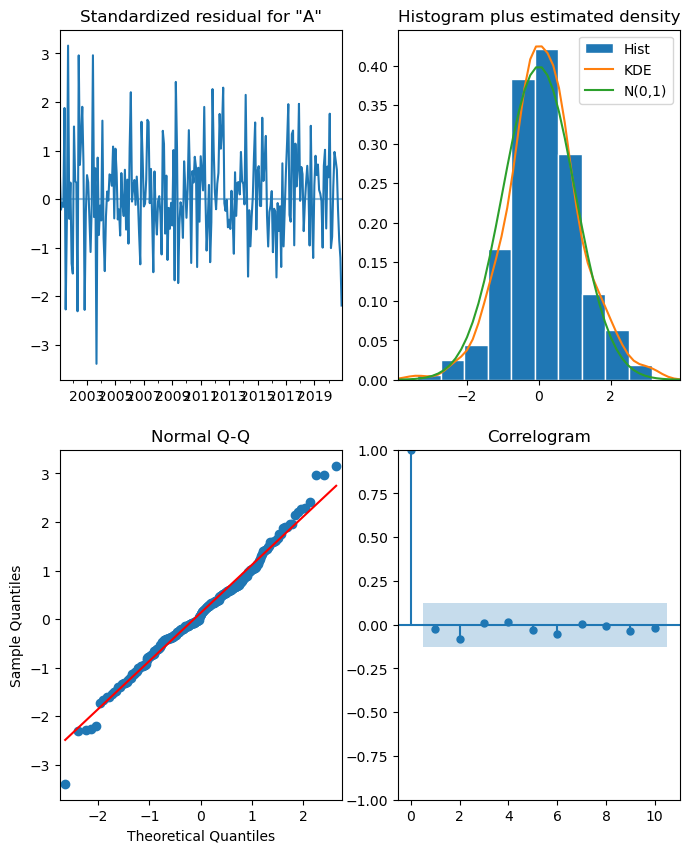

In [17]:
#%%Apply SARIMA, save prediction results
train_sarima = SARIMAX(train, order=(p_s,d_s,q_s), seasonal_order=(P_s,D_s,Q_s,s_s)).fit(disp=-1)
print(train_sarima.summary())
#to check if the residuals are white noise
train_sarima.plot_diagnostics(figsize=(8,10))

unfall_alcohol['SARIMA'] = train_sarima.fittedvalues.round()
unfall_alcohol['SARIMA'][:s_s+d_s] = np.NAN
unfall_alcohol['SARIMA'][test.index] = train_sarima.predict(start=test.index[0], end=test.index[-1]).round()
unfall_alcohol['D_SARIMA'] = (unfall_alcohol['SARIMA']-unfall_alcohol[category[0]])
rmse_sarima = sqrt(mean_squared_error(test, unfall_alcohol['2021']['SARIMA'])) 

## Exponential Smoothing(ETS)

In [18]:
#%%perform AIC, determine parameters for Exponential Smoothing(ETS)
t_e = ['add', 'mul',None]
s_e = ['add', 'mul',None]
p_e = range(12,13)
d_e = [True, False]
model_type = 'ETS'

parameters_ets = list(product(t_e,s_e,p_e,d_e))

warnings.filterwarnings("ignore") 
AIC_ets = AIC(train, parameters_ets, model_type)

t_e, s_e, p_e, d_e = AIC_ets['Parameters'][0]

  0%|          | 0/18 [00:00<?, ?it/s]

In [19]:
#%%perform ETS(Holt-Winter’s Smoothing model)
train_ets = ExponentialSmoothing(train, trend=t_e, seasonal=s_e, seasonal_periods=p_e, damped=d_e).fit()
print(train_ets.summary())

unfall_alcohol['ETS'] = train_ets.fittedvalues.round()
unfall_alcohol['ETS'][test.index] = train_ets.predict(start=test.index[0], end=test.index[-1]).round()
unfall_alcohol['D_ETS'] = (unfall_alcohol['ETS']-unfall_alcohol[category[0]])
rmse_ets = sqrt(mean_squared_error(test, unfall_alcohol['2021']['ETS'])) 

                       ExponentialSmoothing Model Results                       
Dep. Variable:           Alkoholunfälle   No. Observations:                  252
Model:             ExponentialSmoothing   SSE                          15402.564
Optimized:                         True   AIC                           1068.441
Trend:                   Multiplicative   BIC                           1124.912
Seasonal:                      Additive   AICC                          1071.376
Seasonal Periods:                    12   Date:                 Wed, 30 Nov 2022
Box-Cox:                          False   Time:                         22:54:39
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0465381                alpha                 True
smoothing_trend          

## Set data for multivariate time series forecasting

In [20]:
x_train, y_train= create_time_features(train, target=category[0])
x_test, y_test = create_time_features(test, target=category[0])
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Random Forest

In [21]:
reg = RandomForestRegressor(n_estimators = 1000, random_state = 42)
reg.fit(x_train, y_train)
yhat = reg.predict(x_test)
unfall_alcohol['Randomforest'] = np.nan
unfall_alcohol['Randomforest'][test.index] = yhat.round()
rmse_randomforest = sqrt(mean_squared_error(test, unfall_alcohol['2021']['Randomforest'])) 

## Visualisation of results

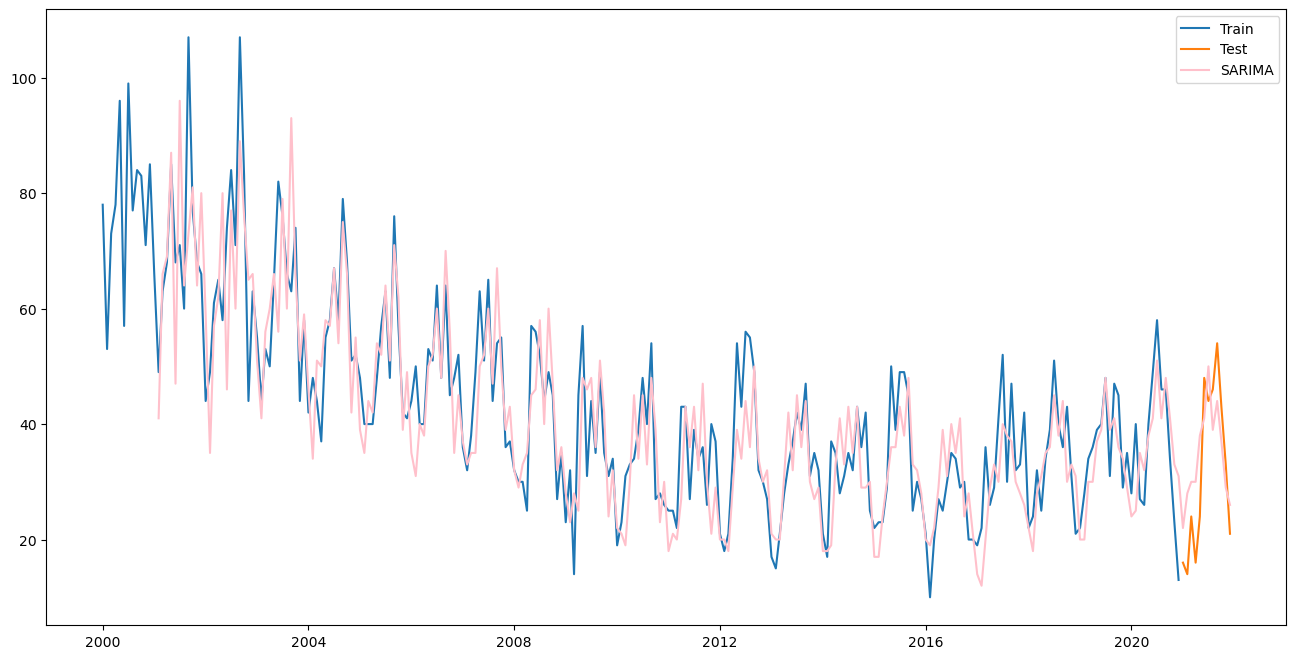

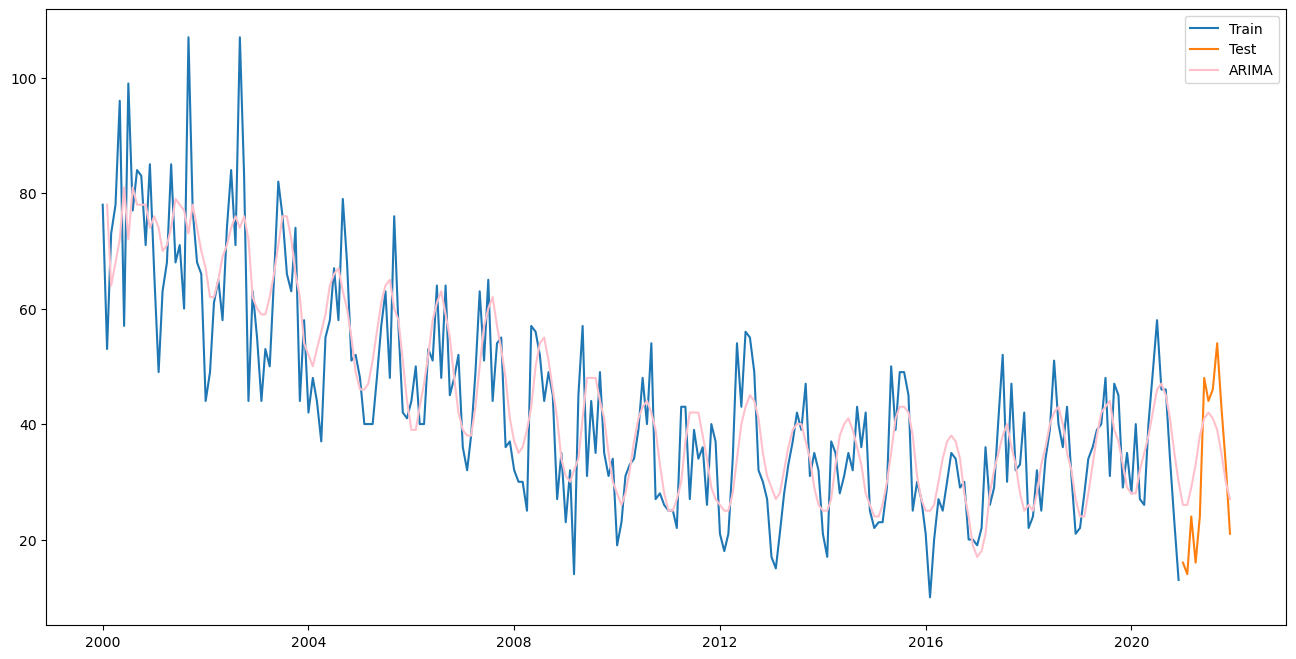

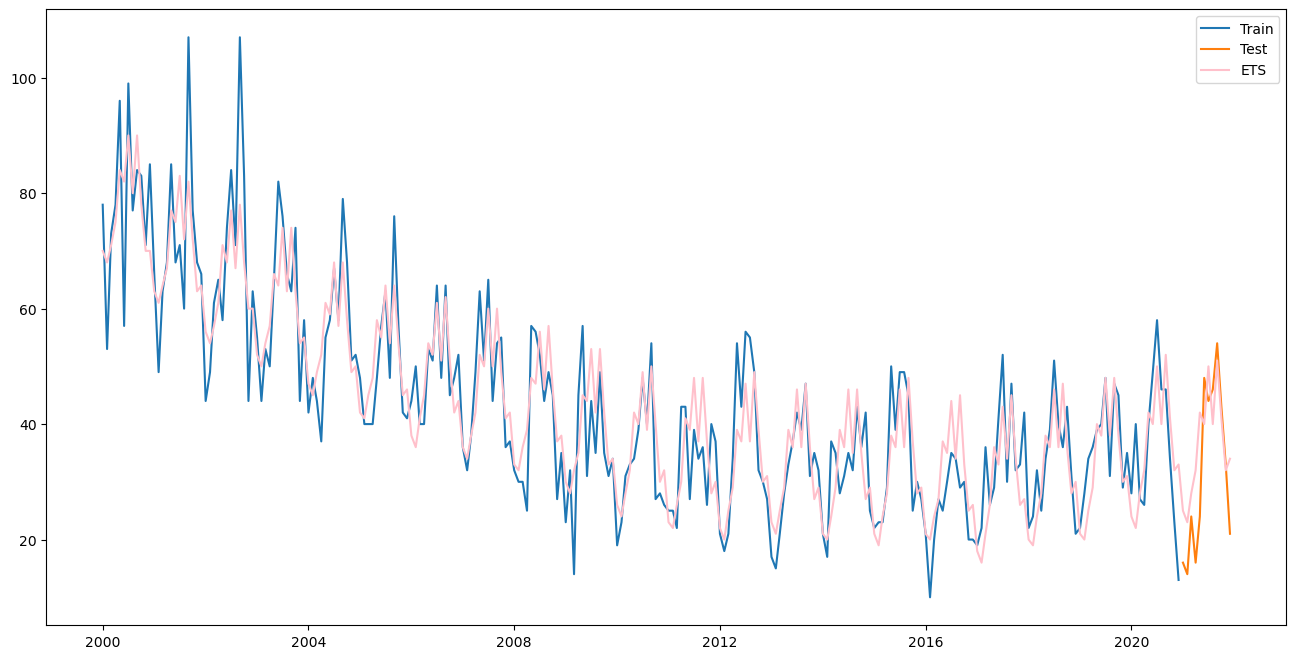

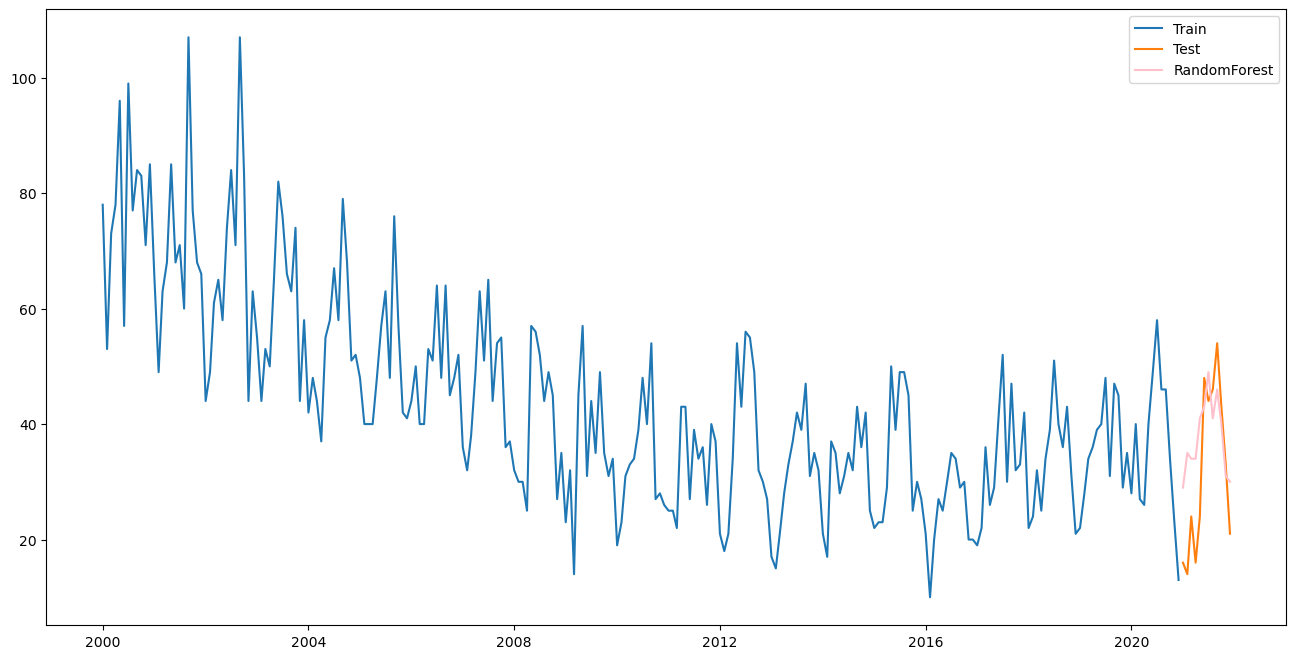

In [23]:
plt.figure(figsize=(16,8))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(unfall_alcohol['SARIMA'],color='pink', label='SARIMA')
plt.legend()
plt.show()


plt.figure(figsize=(16,8))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(unfall_alcohol['ARIMA'],color='pink', label='ARIMA')
plt.legend()
plt.show()

plt.figure(figsize=(16,8))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(unfall_alcohol['ETS'],color='pink', label='ETS')
plt.legend()
plt.show()

plt.figure(figsize=(16,8))
plt.plot(train,label='Train')
plt.plot(test,label='Test')
plt.plot(unfall_alcohol['Randomforest'],color='pink', label='RandomForest')
plt.legend()
plt.show()

In [24]:
print('rmse_sarima: %f\nrmse_arima: %f\nrmse_ets: %f\nrmse_randomforest: %f\n' %(rmse_sarima, rmse_arima, rmse_ets, rmse_randomforest))
print(unfall_alcohol['2021'])

rmse_sarima: 8.995369
rmse_arima: 9.857315
rmse_ets: 9.473648
rmse_randomforest: 11.387127

            Alkoholunfälle  ARIMA  D_ARIMA  SARIMA  D_SARIMA   ETS  D_ETS  \
Date                                                                        
2021-01-01            16.0   26.0     10.0    22.0       6.0  25.0    9.0   
2021-02-01            14.0   26.0     12.0    28.0      14.0  23.0    9.0   
2021-03-01            24.0   29.0      5.0    30.0       6.0  28.0    4.0   
2021-04-01            16.0   33.0     17.0    30.0      14.0  32.0   16.0   
2021-05-01            24.0   38.0     14.0    38.0      14.0  42.0   18.0   
2021-06-01            48.0   41.0     -7.0    41.0      -7.0  40.0   -8.0   
2021-07-01            44.0   42.0     -2.0    50.0       6.0  50.0    6.0   
2021-08-01            46.0   41.0     -5.0    39.0      -7.0  40.0   -6.0   
2021-09-01            54.0   39.0    -15.0    44.0     -10.0  51.0   -3.0   
2021-10-01            43.0   35.0     -8.0    37.0      -6.0 

## Save & Read Model (SARIMA)

In [25]:
#%% save the model into model.pickle
with open('model.pickle','wb') as file:
    pickle.dump(train_sarima,file)

In [26]:
#%% read the model from model.pickle

with open('model.pickle', 'rb') as file:
    model=pickle.load(file)